In [11]:
#IMPORTS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

#STEP 1: LOAD DATA
df = pd.read_csv('USvideos_clean.csv')

# STEP 2: FEATURE ENGINEERING & TARGET DEFINITION 
df['title_length'] = df['title'].apply(len)
df['tag_count'] = df['tags'].apply(lambda x: len(str(x).split('|')))

# Define "Popular" as top 25%
view_threshold = df['views'].quantile(0.75)
df['is_popular'] = (df['views'] >= view_threshold).astype(int)

print(f"Popularity Threshold: {view_threshold:,.0f} views")
print(f"Viral videos: {df['is_popular'].sum()} | Non-viral: {len(df) - df['is_popular'].sum()}")

# STEP 3: TEXT PREPROCESSING (NLP) 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    return " ".join([w for w in words if w not in stop_words])

print("Cleaning text...")
df['clean_title'] = df['title'].apply(clean_text)

#STEP 4: DATA SPLITTING (Train/Test)
# We use 'clean_title' to predict 'is_popular'
X = df['clean_title']
y = df['is_popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#STEP 5: VECTORIZATION (Turning words to numbers)
# 
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#STEP 6: MODEL TRAINING
# 
print("Training Random Forest model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vec, y_train)

#STEP 7: EVALUATIO
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nPROJECT COMPLETE")
print(f"Model Accuracy: {accuracy:.2%}")
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred))

Popularity Threshold: 1,474,750 views
Viral videos: 1588 | Non-viral: 4763
Cleaning text...
Training Random Forest model...


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pramish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



PROJECT COMPLETE
Model Accuracy: 75.30%

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       931
           1       0.57      0.32      0.41       340

    accuracy                           0.75      1271
   macro avg       0.68      0.61      0.63      1271
weighted avg       0.73      0.75      0.73      1271



In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

#STEP 8: PREPARE DATA FOR AI
X = df['clean_title']
y = df['is_popular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} videos...")
print(f"Testing on {len(X_test)} videos...")

#STEP 9: VECTORIZATION ---
print("Vectorizing text...")
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#STEP 10: TRAIN THE MODEL ---
print("Training the Random Forest Model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vec, y_train)

#STEP 11: EVALUATE ---
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n Model Accuracy: {accuracy:.2%}")
print("\n Detailed Report ---")
print(classification_report(y_test, y_pred))

Training on 5080 videos...
Testing on 1271 videos...
Vectorizing text...
Training the Random Forest Model...

 Model Accuracy: 75.30%

 Detailed Report ---
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       931
           1       0.57      0.32      0.41       340

    accuracy                           0.75      1271
   macro avg       0.68      0.61      0.63      1271
weighted avg       0.73      0.75      0.73      1271



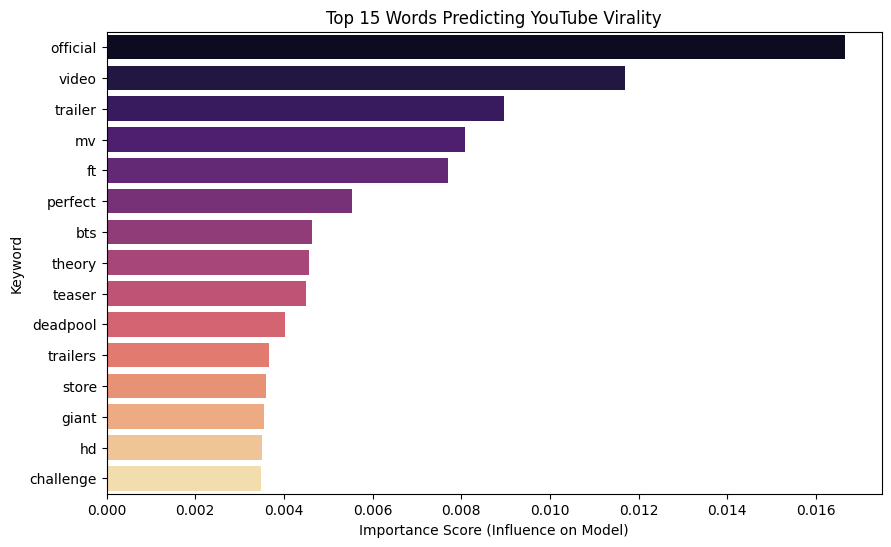

           Word  Importance
3487   official    0.016652
4761      video    0.011683
4626    trailer    0.008967
3376         mv    0.008082
1483         ft    0.007700
3607    perfect    0.005526
556         bts    0.004633
4540     theory    0.004560
4502     teaser    0.004504
967    deadpool    0.004013
4627   trailers    0.003652
4376      store    0.003585
1588      giant    0.003556
1953         hd    0.003511
681   challenge    0.003479


In [13]:
import numpy as np

# 1. Extract the importance scores and the word names
importances = model.feature_importances_
words = vectorizer.get_feature_names_out()

# 2.Organize them into a table
feature_importance_df = pd.DataFrame({'Word': words, 'Importance': importances})

# 3. Sort to see the top 15 most "Viral" words
top_words = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

# 4. Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_words, 
    x='Importance', 
    y='Word', 
    hue='Word',      
    palette='magma', 
    legend=False   
)

plt.title('Top 15 Words Predicting YouTube Virality')
plt.xlabel('Importance Score (Influence on Model)')
plt.ylabel('Keyword')
plt.show()

print(top_words)

In [14]:
#STEP 13: THE VIRAL TITLE TESTER 

def check_my_title(new_title):
    # 1. it will clean the title just like we did for the training data
    clean = clean_text(new_title)
    
    # 2. will turn the words into numbers using our vectorizer
    vec = vectorizer.transform([clean])
    
    # 3. will ask the model to predict (1 = Viral, 0 = Not Viral)
    prediction = model.predict(vec)[0]
    
    # 4. will get the probability score (Confidence)
    prob = model.predict_proba(vec)[0][1]
    
    result = "VIRAL" if prediction == 1 else "NOT VIRAL"
    
    print(f"Title: {new_title}")
    print(f"Prediction: {result}")
    print(f"Confidence: {prob:.2%}")
    print("-" * 30)

#TRY IT OUT
# Test a "Professional" sounding title
check_my_title("Official Music Video - New Hit Song ft. Famous Artist")

# Test a "Standard" sounding title
check_my_title("My daily vlog at the park")

Title: Official Music Video - New Hit Song ft. Famous Artist
Prediction: VIRAL
Confidence: 67.00%
------------------------------
Title: My daily vlog at the park
Prediction: NOT VIRAL
Confidence: 34.24%
------------------------------


In [15]:
import joblib
#step 14
# 1. Save the Model (the brain)
joblib.dump(model, 'youtube_viral_model.pkl')

# 2. Save the Vectorizer (the vocabulary)
# This is crucial because the model only understands the specific number 
# patterns the vectorizer creates!
joblib.dump(vectorizer, 'youtube_vectorizer.pkl')

print("Model and Vectorizer saved successfully as .pkl files!")

Model and Vectorizer saved successfully as .pkl files!


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
#step15
# 1. Calculate the similarity between all titles in our test set
# We use the vectorized data as the computer compares numbers, not words
similarity_matrix = cosine_similarity(X_test_vec)

def get_recommendations(video_index, num_recommendations=5):
    # will get the title of the video the user just watched
    original_title = X_test.iloc[video_index]
    
    # Getting the similarity scores for this specific video
    score_series = list(enumerate(similarity_matrix[video_index]))
    
    # Sort them from highest similarity to lowest
    sorted_scores = sorted(score_series, key=lambda x: x[1], reverse=True)
    
    # Getting the top N results
    top_indices = [i[0] for i in sorted_scores[1:num_recommendations+1]]
    
    print(f"Because you watched: '{original_title}'")
    print("-" * 30)
    print("YOU MIGHT ALSO LIKE:")
    for i in top_indices:
        print(f"- {X_test.iloc[i]}")

#TEST
get_recommendations(10)

Because you watched: 'panettone italian christmas bread food wishes'
------------------------------
YOU MIGHT ALSO LIKE:
- creole crab noodles food wishes spicy crab noodles
- seafood sausage food wishes fish sausage recipe
- chemicals bread make everything
- conan jordan schlanskys italian road trip
- wild christmas
